libraries

In [1]:
# Data Wrangling
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.ensemble import VotingClassifier
from vecstack import stacking
from scipy.stats.mstats import gmean

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
from sklearn.externals import joblib
import pickle
from itertools import combinations
import gc
from tqdm import tqdm
import platform

# Keras
import tensorflow as tf
# Tensorflow warning off
if tf.__version__[0] < '2':
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
import keras
from keras import backend as K
from keras.layers import * #Input, Dense
from keras.models import * #Model
from keras.optimizers import *
from keras.initializers import *
from keras.regularizers import *
from keras.constraints import *
from keras.utils.np_utils import *
from keras.utils.vis_utils import * #model_to_dot
from keras.preprocessing.image import *
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import *

from keras.models import Model, Sequential
from keras import Input
from keras import layers
from keras.optimizers import RMSprop
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping


Using TensorFlow backend.


In [2]:
# 모형 학습 시 RMSE를 계산하는 함수
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 예측값을 저장할 폴더 생성
folder = 'Ensemble'
if not os.path.isdir(folder):
    os.mkdir(folder)

df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()

In [3]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


seed = 2020
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


In [4]:
for i in tqdm(range(5)):    
    SEED = np.random.randint(1, 10000)              
    random.seed(SEED)       
    np.random.seed(SEED)     
    if tf.__version__[0] < '2':  
        tf.set_random_seed(SEED)
    else:
        tf.random.set_seed(SEED)
    
    # Define the NN architecture
    input = Input(shape=(X_train.shape[1],))
    x = Dense(64, activation='elu')(input) #layer1
    x = Dropout(0.3)(x) # drop1
    x1 = Dense(64)(x) # layer1
    x = Add()([x1,x])
    x = Dense(32, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(32)(x)
    x = Add()([x1,x])
    x = Dense(16, activation='elu')(x)
    x = Dropout(0.3)(x)
    x1 = Dense(16)(x)
    x = Add()([x1,x])
    output = Dense(1, activation='relu')(x)
    model = Model(input, output)  
    
    # Choose the optimizer and the cost function
    model.compile(loss='mse', optimizer='adam', metrics=[rmse])
    
    # Train the model
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=64, epochs=100, 
                 callbacks=callbacks, shuffle=False, verbose=0)
    
    print(roc_auc_score(y_valid, model.predict(X_valid)), 'SEED:', SEED)
    
    # Make submissions
    submission = pd.DataFrame({
        "item_id": IDtest, 
        "item_cnt_month": model.predict(X_test).clip(0, 20).flatten()
    })
    t = pd.Timestamp.now()
    fname = f"{folder}/dnn_submission_{t.month:02}{t.day:02}_s{SEED:05}.csv"
    submission.to_csv(fname, index=False)    

 20%|████████████████▊                                                                   | 1/5 [00:02<00:11,  2.93s/it]

0.7527453433416738 SEED: 9057


 40%|█████████████████████████████████▌                                                  | 2/5 [00:05<00:08,  2.86s/it]

0.7492354740061162 SEED: 8840


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:07<00:05,  2.70s/it]

0.7507949332777314 SEED: 2103


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:10<00:02,  2.58s/it]

0.7498436196830691 SEED: 3043


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.56s/it]

0.7456821656936337 SEED: 5221


In [15]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
IDtest = df_test.cust_id.unique()


level = 'gds_grp_nm'

train_test = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()


# 이상치(outlier)를 제거한다.
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

# 왼쪽으로 치우진 분포를 정규분포로 바꾸기 위해 로그 변환을 수행한다. -> 0.769
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

#from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
train_test.iloc[:, 1:] = mmscaler.fit_transform(train_test.iloc[:,1:])

# 특성 차원이 너무 많을 경우 과적합이 발생하기 때문에 차원 축소를 실행한다.
max_d = num_d = train_test.shape[1] - 1
pca = PCA(n_components=max_d, random_state=0).fit(train_test.iloc[:,1:])
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_d = np.argmax(cumsum >= 0.99) + 1             # 분산의 설명량이 99%이상 되는 차원의 수
if num_d == 1: num_d = max_d
pca = PCA(n_components=num_d, random_state=0).fit_transform(train_test.iloc[:,1:])
train_test = pd.concat([train_test.iloc[:,0], pd.DataFrame(pca)], axis=1)
display(train_test)

# 전처리 후 학습용과 제출용 데이터로 분리한다.
X_train = train_test.query('cust_id not in @IDtest').drop('cust_id', axis=1)
X_test = train_test.query('cust_id in @IDtest').drop('cust_id', axis=1)


,cust_id,0,1,2,3,4,5,6,7,8,...,100,101,102,103,104,105,106,107,108,109
0,0,0.625380,0.034396,-0.672246,0.441779,0.159294,-0.598718,0.325886,-0.936302,0.305429,...,-0.143142,0.118564,-0.002334,0.089901,-0.111054,-0.021497,0.140365,0.117912,-0.126485,0.046712
1,1,-1.107635,-0.008147,-0.036582,-0.227227,-0.173067,0.257546,0.036107,-0.059078,-0.073846,...,0.030561,-0.018014,0.032755,0.015114,0.011464,-0.002095,-0.073120,-0.051948,0.005610,-0.007939
2,2,-1.099033,-0.109059,-0.020829,0.007957,-0.059710,0.090729,0.179059,-0.068382,0.062943,...,0.002262,0.035945,-0.017813,-0.008323,-0.036238,0.021623,0.038809,0.046284,0.007039,0.014445
3,3,0.265591,-0.619277,-0.279149,-0.187955,0.023135,-0.135279,-0.067050,0.675716,-0.159730,...,0.131376,0.064030,-0.118500,0.066814,-0.149491,-0.003301,0.486243,-0.482798,-0.028555,-0.156546
4,4,-1.141518,-0.191579,0.005533,-0.059629,0.026487,0.013643,-0.095080,0.043151,-0.057431,...,0.008822,0.004029,0.004533,-0.000862,-0.005974,-0.006765,0.007707,0.013415,-0.002152,0.008844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5977,5977,-0.877498,0.236507,-0.127787,-0.066931,-0.135133,0.047662,0.136196,-0.051518,-0.006189,...,0.100014,-0.477439,-0.028659,0.204758,-0.015639,0.083038,0.010453,-0.005576,-0.006840,0.081172
5978,5978,-1.162111,-0.159106,0.019576,0.078777,0.026611,-0.007421,-0.020261,0.025530,-0.021468,...,0.005455,0.005500,0.013200,0.006884,0.011396,0.006313,-0.050464,-0.032066,-0.036101,-0.007855
5979,5979,0.199450,1.781264,-0.540263,0.071173,0.331206,1.250888,0.351207,-0.141133,-0.117322,...,0.100453,0.028486,-0.128008,0.088439,-0.112445,-0.079405,0.109667,0.038992,-0.088774,0.054421
5980,5980,-0.635700,-0.227858,-0.237216,0.009492,-0.166560,-0.074526,0.129139,-0.274902,-0.380003,...,-0.285796,0.651523,0.113559,-0.241631,0.065565,0.000818,-0.040256,-0.085648,-0.044685,-0.053650


In [16]:
# Input => Dense + Dense + ... => output
# Model(input, output)
 ## 입력층을 먼저 얘기하고, 입력 다음을 케라스에서는 dense라 하는데
    # 이거를 쌓아서 최종 output까지 쌓아줌
# functional x가 무엇이냐
input = Input(shape=(X_train.shape[1],)) # 입력층: X_train의 열의 갯수, 피쳐의 갯수
l1 = Dense(16, activation='relu')(input) # 다음층부터 하나의 층을 하나의 dense라 함
                                        # 첫번째 은닉층의 뉴런이 16개이다.
                                        # Dense 인자에 kernel_initializer, kernel_regularizer, bias_regularizer 등 잇음
d1 = Dropout(0.3)(l1) # 
l2 = Dense(8, activation='relu')(d1) # 이러한 층의 뉴런의 수를 우리가 지정한다. -
                                    # 함수를 relu를 지정햇는데 sigmoid랑 다른 다른 함수이다.
d2 = Dropout(0.2)(l2)    

output = Dense(1, activation='sigmoid')(d2) # 출력층, 하나만 잇으면 되서 뉴런이 1개임(62 -> 16 -> 8 -> 1)
model = Model(input, output) # 모델 셋팅한 것 

# 여기가 굉장히 중요함

In [17]:
# 중간에 차원축소된 부분을 뽑아낼수가 있음
# model = Model(inputs=input_dim, outputs=act) 인풋을 냅두고 아웃풋을 바꿈
# 4000몇개 들어갓을 때 압축된 피쳐를 쓰겟다는 것 PCA된 거라 생각
# 소스코드는 복잡한데 가운데 코드가 제일 좋더라

# Use a middle Bottleneck Layer to Reduce Dimension
hidden_act = [d2] #[encoded1, encoded2, encoded3, decoded1, decoded2]
for ix, act in enumerate(hidden_act):
    model = Model(inputs=input, outputs=act)
    if ix == 0: 
        X_train = model.predict(X_train)
        X_test = model.predict(X_test)
    else:
        X_train = np.hstack([X_train, model.predict(X_train)])
        X_test = np.hstack([X_test, model.predict(X_test)])
        
X_train.shape, X_test.shape

((3500, 8), (2482, 8))

In [19]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7
0,0.412895,0.258090,0.681068,0.186067,0.193855,0.494752,0.141741,0.000000
1,0.000000,0.000000,0.000000,0.083124,0.000000,0.000000,0.000000,0.015982
2,0.000000,0.000000,0.016626,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.057538,0.039844,0.306221,0.073036,0.000000,0.076866,0.000000,0.000000
4,0.000000,0.000000,0.022855,0.012132,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
3495,0.000000,0.000000,0.050592,0.000000,0.000000,0.000000,0.000000,0.000000
3496,0.208784,0.000000,0.184619,0.000000,0.000000,0.475450,0.000000,0.000000
3497,0.000000,0.000000,0.146951,0.000000,0.000000,0.000000,0.062754,0.000000
3498,0.000000,0.000000,0.014944,0.019476,0.000000,0.000000,0.000000,0.000000


In [22]:
X_train.shape[1]

8

In [31]:
i = int(round(X_train.shape[0] * 0.8, 0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_26 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_27 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 66us/step - los

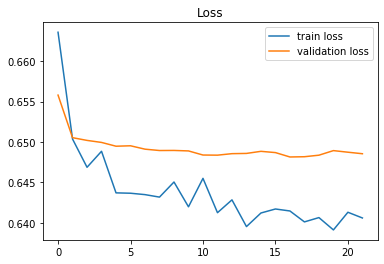

 20%|████████████████▊                                                                   | 1/5 [00:02<00:08,  2.00s/it]

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_28 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_55 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_29 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 67us/step - los

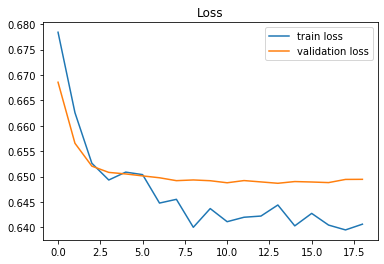

 40%|█████████████████████████████████▌                                                  | 2/5 [00:04<00:06,  2.02s/it]

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_31 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 83us/step - los

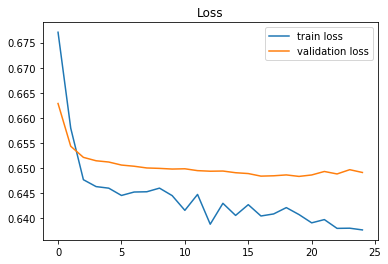

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:06<00:04,  2.14s/it]

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_32 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_61 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 68us/step - lo

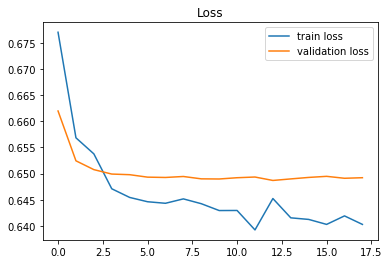

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:08<00:02,  2.08s/it]

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 32)                288       
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_64 (Dense)             (None, 16)                528       
_________________________________________________________________
dropout_35 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 17        
Total params: 833
Trainable params: 833
Non-trainable params: 0
_________________________________________________________________
Train on 2800 samples, validate on 700 samples
Epoch 1/100
2800/2800 [==============================] - 0s 83us/step - lo

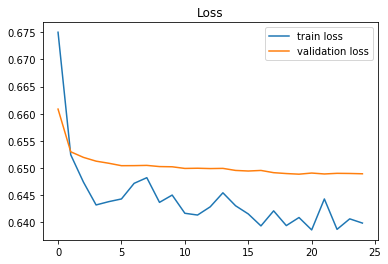

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.21s/it]


In [32]:
for i in tqdm(range(5)):
# Define the number of features
    max_features = X_train.shape[1]

# Define the Model architecture
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(max_features,)))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    # Train the Model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    history = model.fit(X_train, y_train, epochs=100, batch_size=64, 
            validation_data=(X_valid,y_valid), callbacks=[EarlyStopping(patience=5)])

    print(roc_auc_score(y_valid, model.predict(X_valid)))

    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="validation loss")
    plt.legend()
    plt.title("Loss")
    plt.show()